In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.signal
from scipy.fftpack.realtransforms import dct,idct
from scipy import sparse
from siac.utils import diffFilter,filt,dctND,compose_dtd

Consider an inverse correlation function $\mathcal{C}^{-1}$ of the form:

$$
\mathcal{C}^{-1} =  \frac{1}{\sigma_s^2} \left( I + s D^TD \right) = \frac{1}{\sigma_s^2} I +  \frac{1}{\sigma_s^2} s D^TD 
$$
    
where $s$ controls the correlation length and $\frac{1}{\sigma_s^2}$, a function of $s$, normalises the scale.

We can express $D^TD$  as $U^T \Lambda^2 U$ where $U$ is the eigenvector matrix of $D^TD$ and $\Lambda^2$ a diagonal matrix with entries $\lambda_i^2$ for row,column $i$. Then:

$$
\mathcal{C}^{-1} = \frac{1}{\sigma_s^2} \left( I + s U^T \Lambda^2 U \right) 
$$

In [2]:
nr,nc = 4,3


In [3]:
def dcs(nr=4,nc=3):
    r,c = np.mgrid[:nr,:nc]
    index = np.arange(nr*nc)
    # dc
    ofr,ofc = r[c<nc-1].ravel(),c[c<nc-1].ravel()+1
    # for - part
    bigCol = index.reshape(nr,nc)[ofr,ofc]
    bigRow = (index.reshape(nr,nc)[c<nc-1]).ravel()
    ones = np.ones_like(bigCol)
    MinusC = sparse.coo_matrix((-ones,(bigRow,bigCol)),dtype=np.float,shape=(nr*nc, nr*nc))

    # for + part
    bigCol = index.reshape(nr,nc)[ofr,ofc-1]
    bigRow = (index.reshape(nr,nc)[c<nc-1]).ravel()
    ones = np.ones_like(bigCol)
    PlusC = sparse.coo_matrix((ones,(bigRow,bigCol)),dtype=np.float,shape=(nr*nc, nr*nc))
    return PlusC+MinusC

print(dcs().todense())

[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [4]:
def drs(nr=4,nc=3):
    r,c = np.mgrid[:nr,:nc]
    index = np.arange(nr*nc)
    # dr
    ofr,ofc = r[r<nr-1].ravel()+1,c[r<nr-1].ravel()
    # for - part
    bigCol = index.reshape(nr,nc)[ofr,ofc]
    bigRow = (index.reshape(nr,nc)[r<nr-1]).ravel()
    ones = np.ones_like(bigCol)
    MinusR = sparse.coo_matrix((-ones,(bigRow,bigCol)),dtype=np.float,shape=(nr*nc, nr*nc))
    # for + part
    bigCol = index.reshape(nr,nc)[ofr-1,ofc]
    bigRow = (index.reshape(nr,nc)[r<nr-1]).ravel()
    ones = np.ones_like(bigCol)
    PlusR = sparse.coo_matrix((ones,(bigRow,bigCol)),dtype=np.float,shape=(nr*nc, nr*nc))
    return PlusR+MinusR
print(drs().todense())

[[ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [5]:


def DTDmatrix(nr=4,nc=3):
    Dy = drs(nr,nc)
    Dx = dcs(nr,nc)
    DTDx = Dx.T * Dx
    DTDy = Dy.T * Dy
    DTD = DTDx + DTDy
    return DTD,DTDx,DTDy

nr,nc = 4,3
DTD,DTDx,DTDy = DTDmatrix(nr,nc)
print('DTDx')
print(DTDx.todense())
print('DTDy')
print(DTDy.todense())
print('DTD')
print(DTD.todense())

DTDx
[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]
DTDy
[[ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  2.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  2.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  2.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  2.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1

In [6]:
dtd, dtdx, dtdy = compose_dtd(nr, nc)
print('DTDx')
print(dtdx.todense())
print('DTDy')
print(dtdy.todense())
print('DTD')
print(dtd.todense())

DTDx
[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]
DTDy
[[ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  2.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  2.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  2.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  2.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1

In [7]:
# confirm Feng's DTD matrix
DTD - dtd

<12x12 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Column format>

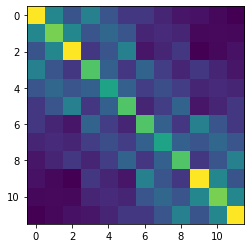

In [8]:
plt.imshow((np.eye(nr*nc) + 10 *  np.matrix(dtd.todense())).I)

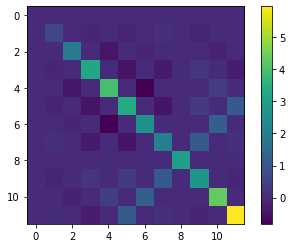

In [119]:
def dctND(data,f=dct,axis=(0,1)):
    return f(f(data,norm='ortho',type=2,axis=0)\
                  ,norm='ortho',type=2,axis=1)
M = DTD.todense()
L = dctND(M)
plt.imshow(L)
plt.colorbar()

which is unexpected as it should be a diagonal matrix.

In [10]:
# define new matrix with -ve differences

def dcs2(nr=4,nc=3):
    r,c = np.mgrid[:nr,:nc]
    index = np.arange(nr*nc)
    # dc
    ofr,ofc = r[c>0].ravel(),c[c>0].ravel()-1
    # for - part
    bigCol = index.reshape(nr,nc)[ofr,ofc]
    bigRow = (index.reshape(nr,nc)[c>0]).ravel()
    ones = np.ones_like(bigCol)
    MinusC = sparse.coo_matrix((-ones,(bigRow,bigCol)),dtype=np.float,shape=(nr*nc, nr*nc))

    # for + part
    bigCol = index.reshape(nr,nc)[ofr,ofc+1]
    bigRow = (index.reshape(nr,nc)[c>0]).ravel()
    ones = np.ones_like(bigCol)
    PlusC = sparse.coo_matrix((ones,(bigRow,bigCol)),dtype=np.float,shape=(nr*nc, nr*nc))
    return (PlusC+MinusC)

print(dcs2().todense())

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]


In [11]:
def drs2(nr=4,nc=3):
    r,c = np.mgrid[:nr,:nc]
    index = np.arange(nr*nc)
    # dr
    ofr,ofc = r[r>0].ravel()-1,c[r>0].ravel()
    # for - part
    bigCol = index.reshape(nr,nc)[ofr,ofc]
    bigRow = (index.reshape(nr,nc)[r>0]).ravel()
    ones = np.ones_like(bigCol)
    MinusR = sparse.coo_matrix((-ones,(bigRow,bigCol)),dtype=np.float,shape=(nr*nc, nr*nc))
    # for + part
    bigCol = index.reshape(nr,nc)[ofr+1,ofc]
    bigRow = (index.reshape(nr,nc)[r>0]).ravel()
    ones = np.ones_like(bigCol)
    PlusR = sparse.coo_matrix((ones,(bigRow,bigCol)),dtype=np.float,shape=(nr*nc, nr*nc))
    return PlusR+MinusR
print(drs2().todense())

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.]]


In [12]:
def DTDmatrix2(nr=4,nc=3):
    Dy = drs(nr,nc)
    Dx = dcs(nr,nc)
    DTDx = Dx.T * Dx
    DTDy = Dy.T * Dy
    DTD = DTDx + DTDy
    return DTD,DTDx,DTDy

nr,nc = 4,3
DTD2,DTDx2,DTDy2 = DTDmatrix2(nr,nc)
print('DTDx')
print(DTDx2.todense())
print('DTDy')
print(DTDy2.todense())
print('DTD')
print(DTD2.todense())

DTDx
[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]
DTDy
[[ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  2.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  2.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  2.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  2.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1

In [13]:
# confirm Feng's DTD matrix
DTDx2 - DTDx

<12x12 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Column format>

1.9923803677280998


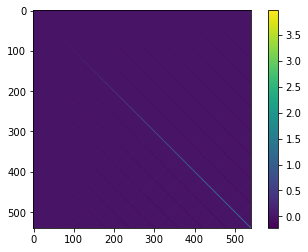

In [162]:
nr,nc = 30,18

# column-wise
dtd,dtdx,dtdy = compose_dtd(nr, nc)
M = dtdx.todense()
Lf = dctND(M)
print(Lf.sum()/(nr*nc))
plt.imshow(Lf)
plt.colorbar()

30 18
1.8888888888888886
3.969615506024416 0.0


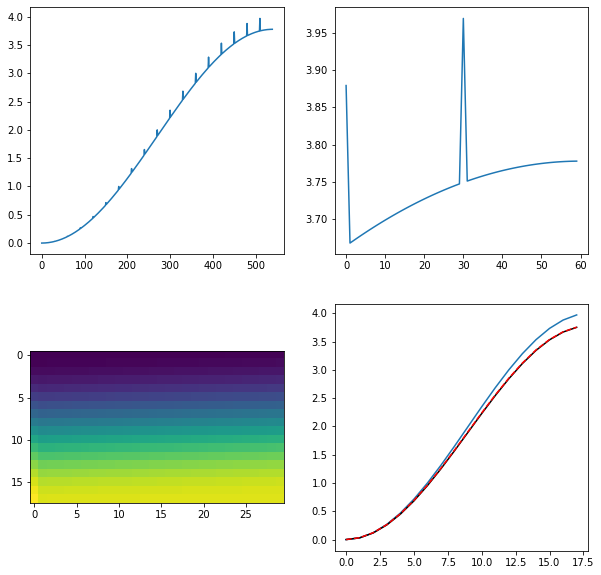

In [169]:
print(nr,nc)

L = np.diag(Lf)
print((L.sum()/(nr*nc)))
L_ = L.reshape(nc,nr)
print(L.max(),L.min())
fig,((ax0,ax1),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax0.plot(L)
ax1.plot((L)[-nr*2:])
_=ax3.imshow(L_)
ax4.plot(L_[:,0])
ax4.plot(L_[:,1],'k')
ax4.plot(L_[:,2],'r--')

30 18
1.9333333333333333
3.989043790736547 0.0


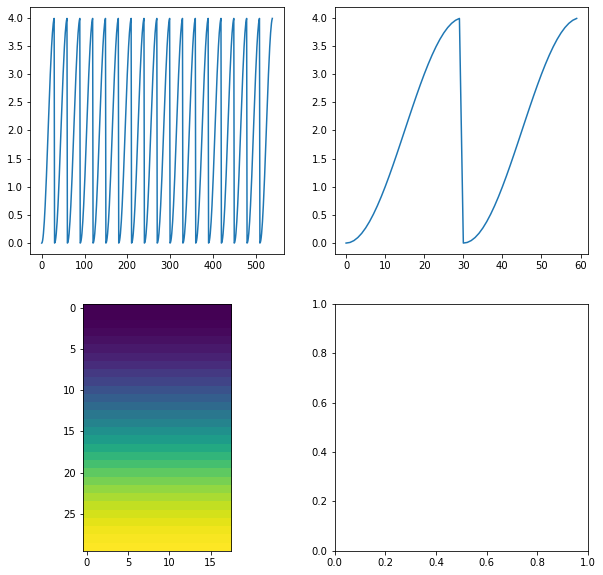

In [164]:
print(nr,nc)
r,c = np.mgrid[:nr,:nc]

omega = np.pi*r/nr
Lambda = 2 - 2 * np.cos(omega)

omega = np.pi*c/nc
#Lambda += 2 - 2 * np.cos(omega)
print(Lambda.sum()/(nr*nc))
print(Lambda.max(),Lambda.min())
fig,((ax0,ax1),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax0.plot(Lambda.T.ravel())
ax1.plot((Lambda.T.ravel())[-nr*2:])
_=ax3.imshow(Lambda)

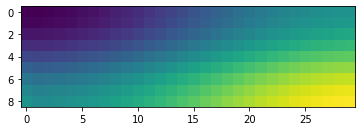

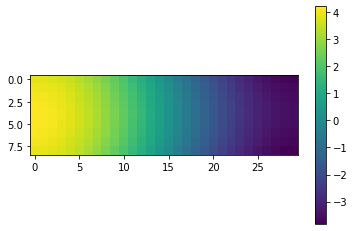

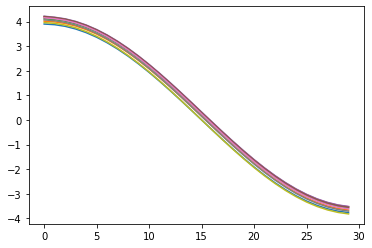

In [150]:
plt.imshow(L_[0::2,:])
plt.figure()
plt.imshow(L_[1::2,:]-L_[0::2,:])
plt.colorbar()
plt.figure()
plt.plot(np.array(L_[1::2,:]-L_[0::2,:]).T)

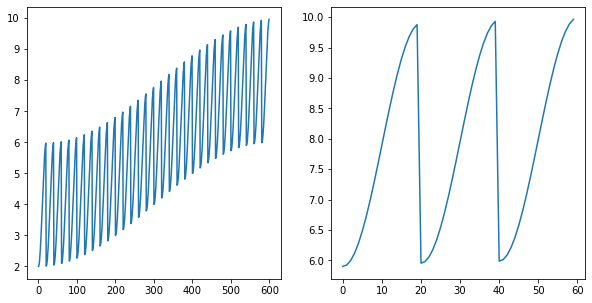

In [67]:
yshape = (nr,nc)
ndim = len(yshape)
Lambda = np.zeros(yshape).astype(float)


    omega = np.pi*np.arange(yshape[i])/float(yshape[i])
    this = -2 + 2 * np.cos(omega).reshape(siz0)
    Lambda = Lambda + this
LF = (len(axis)-Lambda)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.plot(LF.ravel())
ax1.plot((LF.ravel())[-nr*2:])

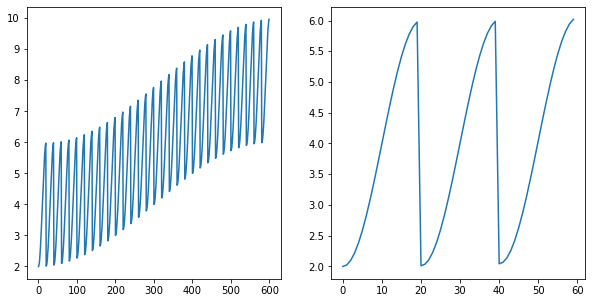

In [63]:
def diffFilter2(yshape,axis=(0,1)):
    '''
    Sqrt DCT-II filter for D2 == D^T D
    
    Returns eigenvalues for order p filter. NB
    Square it when using to obtain the correct filter.
    '''
    ndim = len(yshape)
    Lambda = np.zeros(yshape).astype(float)
    axis_ = np.array(axis)[::-1]
    for c,i in enumerate(axis):
        # create a 1 x d array (so e.g. [1,1] for a 2D case
        siz0 = np.ones((1,ndim)).astype(int)[0]
        siz0[i] = yshape[i]
        
        omega = np.pi*np.arange(yshape[i])/float(yshape[i])
        
        this = -2 + 2 * np.cos(omega).reshape(siz0)
        Lambda = Lambda + this
    Lambda = (len(axis)-Lambda)
    return Lambda

LF = diffFilter2((nr,nc))
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.plot(LF.ravel())
ax1.plot((LF.ravel())[:nr*2])

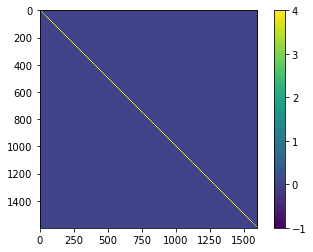

In [147]:
dtd, dtdx, dtdy = compose_dtd(nx, nx)
dtd = dtd.todense()
fdtd = UT  * dtd * U
plt.imshow(fdtd,interpolation='none')
plt.colorbar()

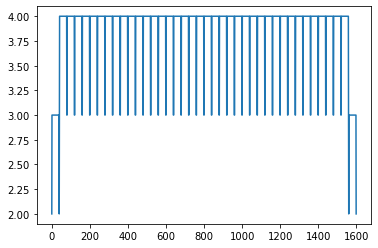

In [148]:
dd = np.diag(fdtd)
plt.plot(dd)

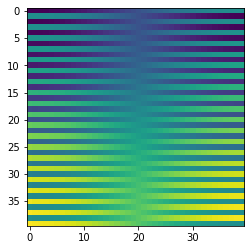

In [116]:
plt.imshow(dd.reshape(nx,nx))

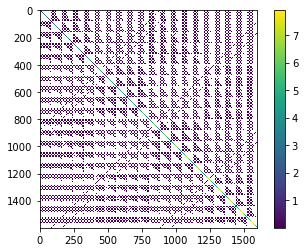

In [103]:

# the diagonals are for row0, row1, ...
Lambda = np.diag(dctND(dtd.todense(),f=dct))
reste = dctND((dtd).todense(),f=dct) 
reste[reste<1e-10] = np.nan
plt.imshow(reste,interpolation='none')
plt.colorbar()

In [47]:
ny = nx
ns = nx * nx
n = int(np.sqrt(ns))
d1 = np.ones(ns)
d1[ny-1::ny] = 1
d1[0::ny] = 1
d1[nx-1::nx] = 0
d2 = np.ones(ns) * -1
d2[ny-1::ny] = 0

d3 = np.ones(ns)
d3[:ny] = 1
d3[ns-ny:] = 0
d4 = np.ones(ns) * -1
dx = sparse.spdiags([d1, d2[::-1]], [0, 1], ns, ns)
dy = sparse.spdiags([d3, d4], [0, ny], ns, ns)
dtdx_ = dx.T * dx
dtdy_ = dy.T * dy
print(dx.todense().astype(int))

[[ 1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


[[ 2 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0]
 [-1  3 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  3 -1  0  0 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  2  0  0  0 -1  0  0  0  0  0  0  0  0]
 [-1  0  0  0  3 -1  0  0 -1  0  0  0  0  0  0  0]
 [ 0 -1  0  0 -1  4 -1  0  0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0 -1  4 -1  0  0 -1  0  0  0  0  0]
 [ 0  0  0 -1  0  0 -1  3  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0  3 -1  0  0 -1  0  0  0]
 [ 0  0  0  0  0 -1  0  0 -1  4 -1  0  0 -1  0  0]
 [ 0  0  0  0  0  0 -1  0  0 -1  4 -1  0  0 -1  0]
 [ 0  0  0  0  0  0  0 -1  0  0 -1  3  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0  2 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0 -1  0  0 -1  3 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  3 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0 -1  2]]


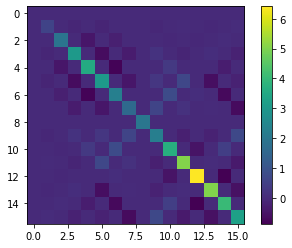

In [51]:
#print(dtdx_.todense().astype(int))
dtd_ = dtdy_+dtdx_
print((dtd).todense().astype(int))
Lambda = np.diag(dctND((dtdy_+dtdx_).todense(),f=dct))
reste = dctND(dtd_.todense(),f=dct) 
plt.imshow(reste)
plt.colorbar()

In [16]:
def sparseSVD(D):
    import scipy.sparse
    try:
        import sparsesvd
    except:
        print('bummer ... better get sparsesvd')
        print('!pip install sparsesvd')
    Ds = scipy.sparse.csc_matrix(D)
    a = sparsesvd.sparsesvd(Ds,Ds.shape[0])
    return a

n=nx
I = np.identity(n)
 
# define a 'traditional' D1 matrix
# which is a right-side difference
# and which is *not* symmetric :-( 
D1 = np.matrix(I - np.roll(I,1))
# so define a symemtric version
D1a = D1.T - D1

D1.T

matrix([[ 0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.],
        [ 0., -1.,  1.,  0.],
        [ 0.,  0., -1.,  1.]])

In [ ]:
U, s, Vh = scipy.linalg.svd(D1a)

# now, get eigenvectors for D1a
Ut,eigenvalues,Vt = sparseSVD(D1a)
Ut = np.matrix(Ut)


# then, an equivalent 2nd O term would be
D2a = D1a**2

# show we can recover D1a
D1a_est = Ut.T * np.diag(eigenvalues) * Ut


# Now, because D2a (& the target D1a) are symmetric:
D1a_est = Ut.T * np.diag(eigenvalues**0.5) * Ut


D = 2*I - (np.roll(I,-1) + np.roll(I,1))
a = sparseSVD(-D)
eigenvalues = np.matrix(a[1])
Ut = np.matrix(a[0])
Vt = np.matrix(a[2])
orig = (Ut.T * np.diag(np.array(eigenvalues).flatten()) * Vt)

Feigenvalues = np.diag(np.array(np.c_[eigenvalues,0]).flatten())
FUt = np.c_[Ut.T,np.zeros(Ut.shape[1])]
# confirm: FUt * Feigenvalues * FUt.T ~= D


# m is a 1st O difference matrix
# with careful edge conditions
# such that m.T * m = D2
# D2 being a 2nd O difference matrix
m = np.matrix(np.identity(100) - np.roll(np.identity(100),1))
m[-1,-1] = 0
m[0,0] = 1
a = sparseSVD(m)
eigenvalues = np.matrix(a[1])
Ut = np.matrix(a[0])
Vt = np.matrix(a[2])
orig = (Ut.T * np.diag(np.array(eigenvalues).flatten()) * Vt)
# Vt* Vt.T = I
# Ut.T * Ut = I
# ((Vt.T * (np.diag(np.array(eigenvalues).flatten())**2)) * Vt)
# we see you get the same as m.T * m by squaring the eigenvalues



and:

$$
\mathcal{C} = \sigma_s^2 U^T\Gamma^2 U 
$$

with $\Gamma^2$ a diagonal matrix with entries $\gamma_i^2$. Then:

$$
\gamma_i^2 =  \left( 1  + s \lambda_i^2 \right)^{-1}
$$

The normalisation factor $\frac{1}{\sigma_s^2}$ is the trace of $\Gamma^2$ divided by $n_x$, which we can write as:

$$
\frac{1}{\sigma_s^2} = \frac{1}{n_x \times n_y}\sum^{j=n_j }_{j=1}  \sum^{i=n_x }_{i=1} \gamma_{i,j}^2 = \overline{\gamma^{2}}
$$

So, asymptotically (for large $n_x$):


$$
\mathcal{C} = \sigma_s^2 U^T\Gamma^2 U 
$$

with $\sigma_s^2 = 1/\overline{\gamma^{2}}$. 

In [ ]:
gammas = np.array([ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, \
                   1, 2, 3, 4, 5, 6, 7, 8, 9, \
                   1e1,50])
gamma_small = np.array([ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5])
gammas = np.concatenate([gamma_small,np.arange(1,50)])
ss = gammas**2
print(ss.min(),ss.max())
print(ss)

In [ ]:
def getF(s,nx=None):
    # make nx quite big to avoid edge effects
    if nx is None:
        nx = int(500*s/10)
        nx = np.min([5000,np.max([1000,nx])])
    
    shape = (nx,nx)
    halfx = int(nx/2)
    lambda_i = diffFilter(shape,axis=(0,1))
    gamma_i2 = 1/(1 +  s * lambda_i * lambda_i)
    gamma2bar = np.mean(gamma_i2)  
    sigmas = np.sqrt(1./gamma2bar)
    
    # impulse function
    I = np.zeros(shape)
    I[halfx,halfx]=1
    F = filt(I,gamma_i2 * sigmas**2) 
    return F.max(),F,nx,sigmas

ts = np.zeros_like(ss).astype(float)
ns = np.zeros_like(ss).astype(float)
sigmas = np.zeros_like(ss).astype(float)

for i,s in enumerate(ss):
    print(f'{s}',end='..')
    ts[i],a,ns[i],sigmas[i] = getF(s)

In [ ]:
# check the normalisation works
# if it does, then ts which is
# C_max should be 1.0
plt.figure(figsize=(10,5))
plt.plot(ss,ts,'+')
plt.xlabel('$\gamma$')
_=plt.ylabel('$\mathcal{C}_{\max}$')

In [ ]:
# save the results
d = {'s':ss, 'gamma':gammas,'sigmas':sigmas,\
     'scale test':ts,'ns':ns }
np.savez('sigmaLUT.npz',**d)

Examine $\sigma_s^2$  = $1/\overline{\gamma^{2}}$ as a function of $s$:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

npow = 2
X = np.array([gammas**i for i in range(1,npow)]).T
y = sigmas
model = LinearRegression()
model.fit(X, y)
yhat = model.predict(X)
mse = mean_squared_error(y, yhat)
print(f'rmse: {np.sqrt(mse):.2f}')
print(model.coef_)

plt.plot(gammas,sigmas)

# the main effect
# for low s is 
# sigmas ~= 1 + gammas*k
# with k ~= 1.1
plt.plot(gammas,yhat,'g--')
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel('$\sqrt{s}$')
_=plt.ylabel('$\sigma_s$')

One interesting feature  is that for low to moderate $s$ (up to 25 perhaps) we have $\sigma_s \approx 1 + 1.035 \sqrt{s}$ (the green line above).

## Implications

So we have the inverse correlation function:


$$
\mathcal{C}^{-1} =  \sigma_s^{-2} \left( I + s D^TD \right) = \sigma_s^{-2} I +  \sigma_s^{-2} s D^TD 
$$

with $\sigma_s \approx 1 + 1.05 \sqrt{s}$.

which leads to the inverse covariance function:

$$
C^{-1} =  \frac{1}{\sigma_s^2 \sigma_x^2} \left( I + s D^TD \right) = \frac{1}{\sigma_s^2  \sigma_x^2}  I +  \frac{1}{\sigma_s^2  \sigma_x^2}  s D^TD  
$$

and the covariance function:

$$
C = \sigma_s^2 \sigma_x^2 U^T  \Gamma^2 U
$$

so, e.g. we have $\sigma_x = 0.3$ and $s = 1600$ (high)

So the covariance function should be:

In [ ]:
s = 1600
sigma_x = 0.3
# set gammas

# LUT to get sigma_s
gamma = np.sqrt(s)
ilut = np.argmin(np.abs(gammas - gamma))
sigma_s = sigmas[ilut]
gamma2bar = 1./(sigma_s*sigma_s)

print(gammas[ilut],gamma)
print('lut',sigma_s)

nx = 300
shape = (nx,nx)
halfx = int(nx/2)

# eigenvalues
lambda_i = diffFilter(shape,axis=(0,1))
gamma_i2 = 1/(1 +  s * lambda_i * lambda_i)

# this will vary slightly with sx
print('explicit',np.sqrt(1./gamma_i2.mean()))

# impulse function
I = np.zeros(shape)
I[halfx,halfx]=1

# from above 
C = filt(I,gamma_i2) * (sigma_s*sigma_s) * (sigma_x * sigma_x)

fig,(im1,im2) = plt.subplots(1,2,figsize=(10,3))
im = im1.imshow(C)
im1.set_title("explicit calculation")
fig.colorbar(im, ax=im1)

# use getF to see impact of nx
Ca = getF(s,nx=nx)[1]* (sigma_x * sigma_x)
im = im2.imshow(Ca)
im2.set_title("test fn")
fig.colorbar(im, ax=im2)

print(len(np.where(C>0)[0]))
print(C.max(),Ca.max(),sigma_x*sigma_x)

$$
C = \sigma_s^2 \sigma_x^2 U^T  \Gamma^2 U
$$

So, if e.g. we design a prior covariance constraint for DA, we can phrase it as:
$$
C^{-1} =  \frac{1}{\sigma_s^2 \sigma_x^2} \left( I + s D^TD \right) 
$$

or, in the form of Lewis et al. (2012):

$$
C^{-1} =  \frac{1}{\sigma_p^2}  I + \gamma^2 D^TD 
$$

To use this form, we need to set:

$$
\sigma_p^2 = \sigma_s^2 \sigma_x^2
$$

and 

$$
\gamma^2 = \frac{s}{\sigma_s^2 \sigma_x^2} \approx \frac{s}{ \sigma_x^2 (1 + \sqrt{s})^2}
$$

In [ ]:
# set the intended terms
s = 1600
sigma_x = 0.3
#######

# LUT to get sigma_s
gamma = np.sqrt(s)
ilut = np.argmin(np.abs(gammas - gamma))
sigma_s = sigmas[ilut]
print(gammas[ilut],gamma)
print('lut',sigma_s)

# use these in Lewis et al formulae
sigma_p2 = (sigma_s*sigma_s) * (sigma_x * sigma_x)
gamma2 = s / sigma_p2
print(f'desired:     {np.sqrt(s):.2f} {sigma_x:.2f}')
print(f'transformed: {np.sqrt(gamma2):.2f} {np.sqrt(sigma_p2):.2f}')
print(f'approx {1/(np.sqrt(2)*sigma_x):.2f}')
print(f'inflation factor on sigma_x {sigma_s:.2f}')

In [ ]:
nx = 300
shape = (nx,nx)
halfx = int(nx/2)

# eigenvalues
lambda_i = diffFilter(shape,axis=(0,1))
# full form
gamma_i2 = 1/(1/sigma_p2 +  gamma2 * lambda_i * lambda_i)

# impulse function
I = np.zeros(shape)
I[halfx,halfx]=1

# from above 
C_ = filt(I,gamma_i2) 

fig,(im1,im2) = plt.subplots(1,2,figsize=(10,3))
im = im1.imshow(C)
im1.set_title("original calculation")
fig.colorbar(im, ax=im1)

# use formula here
im = im2.imshow(C_)
im2.set_title("test fn")
fig.colorbar(im, ax=im2)

In [ ]:
plt.title('inflation factor $\sigma_s$ on $\sigma_x$')
plt.plot(gammas,sigmas,'+-')
plt.plot(gammas,(1+gammas),'r--')
plt.xlabel('$\sqrt{s}$')
plt.xlabel('$\sigma_s$')

## Conclusions

To use Lewis form to describe prior covariance function, for some desired prior variance $\sigma_x^2$ and smoothness factor $s$, you need to scale $\sigma_x$ by a factor $\sigma_s$ given by the LUT here or $\approx (1 + \sqrt{s})$. 

You also need to use:

$$
\gamma^2 = \frac{s}{\sigma_s^2 \sigma_x^2} \approx \frac{s}{ \sigma_x^2 (1 + \sqrt{s})^2}
$$


In [ ]:

def scaler(sigma_x,s):
    '''
    warning: dont use beyond extent of training
    ... its only a LUT!
    '''
    d = np.load('sigmaLUT.npz')
    gammas = d['gamma']
    # LUT to get sigma_s
    gamma = np.sqrt(s)
    ilut = np.argmin(np.abs(gammas - gamma))
    sigma_s = sigmas[ilut]
    sigma_p = sigma_s*sigma_x
    return sigma_p,s/(sigma_p**2)

In [ ]:
print(scaler(0.3,10))

In [ ]:
print(scaler(0.3,5))

In [ ]:
print(scaler(0.3,2))